This notebook uses a test function to demonstrates a situation where, close to center, the values of the function are small compared to near the extremeties of the domain. This situation might arise in aerodynamics for example, where extreme flight conditions yield large values of the force coefficients (_e.g._ high angles of attack), but at normal flight conditions (_e.g._ low angles of attack) those values are small in comparison. This results is a situation where data collected homogeneously over the domain contains outliers (extreme flight conditions) that skew the distribution. Removing the outliers is not an option, since those points are physical and must be predicted. 

This is a challenging situation for surrogate models because they learn by minimize some global easure of error. Hence, a few extreme sample points with large values will yield large prediction error for an untrained model. These large prediction errors dominate during training, such that the model learns to predict large values better than smaller values, which remain in the "noise" of the surrogate. 

This notebook uses a simple 1D function to illustrate such a situation. There are two tools that can be used to remedy this situation. The first is applying some transformation to the data (_e.g._ sigmoid or log) that effective "squishes" the data such that data values are closer in magnitude (_i.e._ no extreme differences). 

The second tool, if it available, is to leverage gradient information. Partial derivatives have the property that they can be large, even if the value of the response at the point where they are computed is small. There, adding an extra term in the cost function that accounts for partial derivatives helps to rebalance the relative importance of data points. Indeed, there will be a larger penalty for failing to predict the gradient accurately, which should help improve the prediction everywhere in the domain. This notebooks illustrates this.  

In [1]:
from jenn import JENN
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Try turning these various options on/off and observe the prediction differences. Turning GENN, normalization and applying a log transformation yields a nearly perfect prediction, whereas a regular neural net fails to predict small values well. 

In [2]:
NUMBER_TRAIN_POINTS = 30
IS_TRANSFORM = True
IS_NORMALIZE = True

# Test Function

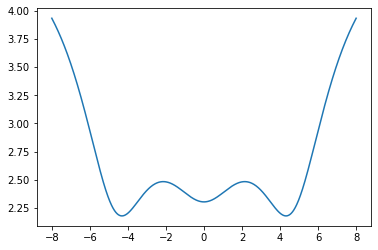

In [3]:
def finite_diff(x, f, dx=1e-6): 
    return (f(x+dx) - f(x-dx)) / (2 * dx)

a = 4
c = .3
    
z = lambda x: x * np.sin(x) + (c * x) ** a + 10
dz_dx = lambda x: np.sin(x) + x * np.cos(x) + a * c * (c * x) ** (a - 1)

if IS_TRANSFORM: 
    f = lambda x: np.log(z(x))
    df_dx = lambda x: dz_dx(x) / z(x)  
else:
    f = lambda x: z(x)
    df_dx = lambda x: dz_dx(x)
    
x = np.linspace(-8., 8., 1000)
y = f(x)
plt.plot(x, y)

assert np.allclose(df_dx(x), finite_diff(x, f))

# Test Data

In [4]:
lb = -8
ub = 8

n_x = 1  # number of inputs
n_y = 1  # number of outputs

m = 60  # number of test examples
X_test = lb + np.random.rand(m, 1).reshape((m, n_x)) * (ub - lb)
Y_test = f(X_test).reshape((m, n_y))
J_test = df_dx(X_test).reshape((m, n_y, n_x))

# Training Data

In [5]:
lb = -8
ub = 8

n_x = 1  # number of inputs
n_y = 1  # number of outputs

m = NUMBER_TRAIN_POINTS
X_train = np.linspace(lb, ub, m).reshape((m, n_x))
Y_train = f(X_train).reshape((m, n_y))
J_train = df_dx(X_train).reshape((m, n_y, n_x))

# Regression

_GENN_

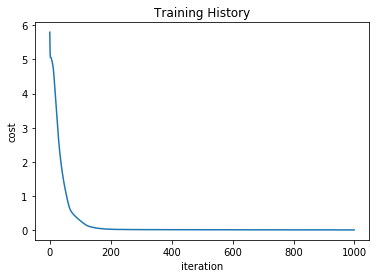

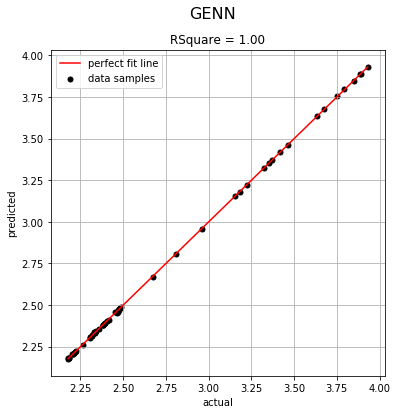

In [8]:
jenn = JENN(hidden_layer_sizes=(12, ), activation='tanh',
             num_epochs=1, max_iter=1000, batch_size=None,
             learning_rate='backtracking', random_state=0, tol=1e-6,
             learning_rate_init=0.05, alpha=1e-6, gamma=1,
             verbose=False)

jenn.fit(X_train, Y_train, J_train, is_normalize=IS_NORMALIZE)
history = jenn.training_history()
fig = jenn.goodness_fit(X_test, Y_test, title='GENN', show_error=False)[0]
# fig.savefig('GENN_demo_3.png', dpi=300)

_NN_

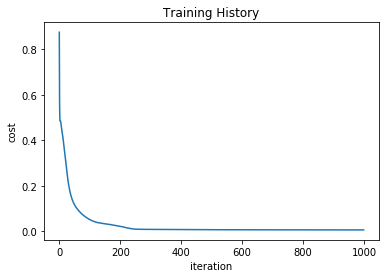

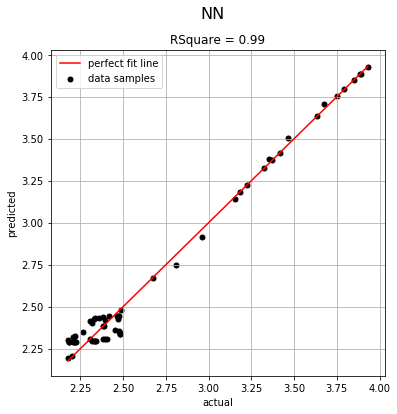

In [9]:
nn = JENN(hidden_layer_sizes=(12, ), activation='tanh',
          num_epochs=1, max_iter=1000, batch_size=None,
          learning_rate='backtracking', random_state=0, tol=1e-6,
          learning_rate_init=0.05, alpha=1e-8, gamma=0,
          verbose=False)

nn.fit(X_train, Y_train, J_train, is_normalize=IS_NORMALIZE)
history = nn.training_history()
fig = nn.goodness_fit(X_test, Y_test, title='NN', show_error=False)[0]
# fig.savefig('NN_demo_3.png', dpi=300)

# Plots

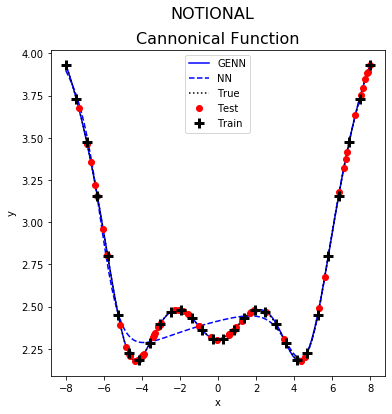

In [11]:
X = np.linspace(lb, ub, 100).reshape((-1, n_x))
Y_true = f(X)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6, 6))
fig.suptitle('NOTIONAL', fontsize=16)
spec = gridspec.GridSpec(ncols=1, nrows=1, wspace=0.25)

# Plot
ax = fig.add_subplot(spec[0, 0])
ax.set(xlabel='x', ylabel='y')

Y_pred = jenn.predict(X)
ax.plot(X, Y_pred, 'b-')

Y_pred = nn.predict(X)
ax.plot(X, Y_pred, 'b--')

ax.plot(X, Y_true, 'k:')

ax.plot(X_test, Y_test, 'ro')
ax.plot(X_train, Y_train, 'k+', mew=3, ms=10)

ax.legend(['GENN', 'NN', 'True', 'Test', 'Train'])

plt.title('Cannonical Function', fontsize=16)

plt.show()
fig.savefig('S3F1_Curve.png', dpi=300)